# Extract and transform CFSv2 output subsets from NCEI THREDDS server

- 2020-11-5. https://github.com/emiliom/
- Run with conda environment https://github.com/snowmodel-tools/postprocess_python/blob/master/snowmodelaws_env.yml

Define and execute a remote request for CFSv2 model output. The user specifies the geographic bounding box (in lat-lon coordinates) and the output projection (as EPSG code) and cell resolution (in meters).

The overall approach may be grouped into several overarching steps:
1. Crawl the THREDDS catalog and compile the target set of grib2 (`.grb2`) file names and urls (THREDDS datasets) across the tree hierarchy
2. Set spatial and temporal criteria for desired subset
3. Filter the list of grib2 files based on the temporal criteria.
4. Execute subset and data access requests, one grib2 file at a time, using the filtered list of grib2 files and returning a collection (list) of xarray datasets; one file corresponds to one timestep.
5. Concatenate the individual xarray datasets and clean up the result, simplifying the structure and adding conformant projection information.
6. Reproject and resample to the desired UTM projection.
7. Export to netcdf file

Currently the code uses this model product: [CFSv2 Operational Forecasts - 9-Month Forecasts: 6-Hourly Surface and Radiative Fluxes (FLX)](https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/climate-forecast-system-version2-cfsv2#CFSv2%20Operational%20Forecasts). More specifically, it's hard-wired to seek the latest 2020 model run, identify the THREDDS catalog (equivalent to a directory) for this run, and access the data from the start of the run to a number of forecast days defined by the user.

**It appears that we should instead use the [CFSv2 Operational Analysis - 6-Hourly Surface and Radiative Fluxes (FLX)](https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/climate-forecast-system-version2-cfsv2#CFSv2%20Operational%20Analysis).**

For additional background on CFSv2 see https://github.com/snowmodel-tools/preprocess_python/issues/17

In [1]:
%matplotlib inline
from datetime import datetime, timedelta

import dateutil
from dateutil.parser import parse as duparse
from siphon.catalog import TDSCatalog
import xarray as xr
from xarray.backends import NetCDF4DataStore
from pyproj import CRS
from rasterio.warp import Resampling
import rioxarray

## Query settings

Geographical bounding box. Currently set to WY model domain.

In [2]:
geobbox = dict(
    south=42.363116,
    west=-111.155208,
    north=44.582480,
    east=-109.477849
)

Currently hard-wired to ingest data from a specified year. The scheme will find and select the latest model run in that year.

In [3]:
year = 2020

**Reprojection and resampling user settings**

In [4]:
to_crs = 'epsg:32612'
to_resolution = 50000 # in meters (50 km)

## Set the THREDDS catalog and extract target set of grb2 datasets

The target is not the final query set, but rather the "population" of grb2 datasets (file paths) that will be queried.

### Set and describe the top-level THREDDS catalog

In [5]:
cfsv2_cat = TDSCatalog(f"https://www.ncei.noaa.gov/thredds/catalog/model-cfs_v2_for_6h_flxf/{year}/catalog.xml")

Returns only `catalog_ref` and no `datasets` (catalog vs leaf datasets)

In [6]:
vars(cfsv2_cat)

{'catalog_url': 'https://www.ncei.noaa.gov/thredds/catalog/model-cfs_v2_for_6h_flxf/2020/catalog.xml',
 'base_tds_url': 'https://www.ncei.noaa.gov',
 'catalog_name': 'No name found',
 'datasets': [],
 'services': [<siphon.catalog.CompoundService at 0x7f1147594fd0>],
 'catalog_refs': ['202011', '202010', '202009', '202008', '202007', '202006', '202005', '202004', '202003', '202002', '202001'],
 'metadata': {'inherited': True, 'serviceName': 'fileServices'},
 'ds_with_access_elements_to_process': []}

In [7]:
cfsv2_cat.catalog_refs

['202011', '202010', '202009', '202008', '202007', '202006', '202005', '202004', '202003', '202002', '202001']

The most recent catalog_ref dataset is found as the first list entry; that is, the entries are sorted in descending chronological order.

Crawl down the tree, to the last catalog_ref dataset (eg, 2020101718)

### Crawl to the last catalog dataset and extract grb2 datasets
The last (in the catalog tree) catalog dataset is the the one that contains the individual GRIB2 datasets

In [8]:
grbdata_catref = cfsv2_cat.catalog_refs[0].follow().catalog_refs[0].follow().catalog_refs[0]
grbdata_catref

2020110218

In [9]:
grbdata_cat = grbdata_catref.follow()

In [10]:
print(f"# of catalog datasets: {len(grbdata_cat.catalog_refs)}   # of leaf datasets: {len(grbdata_cat.datasets)}")

# of catalog datasets: 0   # of leaf datasets: 2529


In [11]:
grbdata_cat.catalog_url

'https://www.ncei.noaa.gov/thredds/catalog/model-cfs_v2_for_6h_flxf/2020/202011/20201102/2020110218/catalog.xml'

Filter to retain only `.grb2` files ("datasets") that start with the file name prefix "flxf". Return a list of tuples where the second element is a datetime object parsed from the dataset file name.

In [12]:
grb2datasets = [
    (dname, duparse(dname.split(sep='.')[0][4:] + '00')) for dname in grbdata_cat.datasets 
    if dname.startswith('flxf') and dname.endswith('.grb2')
]

In [13]:
len(grb2datasets)

842

In [14]:
grb2datasets[0], grb2datasets[-1]

(('flxf2021060100.01.2020110218.grb2', datetime.datetime(2021, 6, 1, 0, 0)),
 ('flxf2020110218.01.2020110218.grb2', datetime.datetime(2020, 11, 2, 18, 0)))

## Data request and filtering
Includes filtering and selection scheme.

CFSv2 variables used:

In [15]:
variable_names = [
    'Temperature_height_above_ground',
    'Geopotential_height_surface',
    'u-component_of_wind_height_above_ground',
    'v-component_of_wind_height_above_ground',
    'Pressure_surface',
    'Specific_humidity_height_above_ground',
    'Precipitation_rate_surface',
    'Downward_Long-Wave_Radp_Flux_surface',
    'Downward_Short-Wave_Radiation_Flux_surface'
]

In [16]:
def get_subset_as_xrds(tds_ds, var_lst, bbox):
    """ Request a geographical and variable subset for the specified dataset (one time step).
    Returns an xarray dataset.
    """
    # Interface with the data through the NetCDF Subset Service (NCSS)
    ncss = tds_ds.subset()

    # Create an NCSS query with our desired specifications
    query = ncss.query()
    query.all_times()
    query.variables(*var_lst)
    query.lonlat_box(**bbox)
    query.accept('netcdf')  # or netcdf4?

    # Use the query to obtain NetCDF data
    data = ncss.get_data(query)
    data_ds = xr.open_dataset(NetCDF4DataStore(data))
    
    return data_ds

In [17]:
def concatds_cleanup(ds_lst, crs, grid_mapping_name='crs'):
    """ Concatenate and clean up list of xarray datasets.
    Write in and clean up the CRS / `grid_mapping` attributes. Shift longitude values from 0 to 360 to -180 to +180.
    In order to be able to use `rio.reproject`, and to generate a less complex xarray dataset. Specifically:
    - Insert the information (height) into attributes in the corresponding variables, 
      from the `height_above_ground` and `height_above_ground1` variables
    - Remove (squeeze) those dimensions from the variables currently using them
    - Remove the coordinate variables themselves
    """
    
    ds = xr.concat(ds_lst, dim='time').drop_vars('GaussLatLon_Projection')
    ds.rio.write_crs(crs, grid_mapping_name=grid_mapping_name, inplace=True);

    # longitude rewrap
    lon_attrs = ds.lon.attrs
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    ds.lon.attrs = lon_attrs

    # height_above_ground simplification
    height_dim_names = ['height_above_ground', 'height_above_ground1']
    for dim_name in height_dim_names:
        for data_var_name in ds.data_vars:
            data_var = ds[data_var_name]
            if dim_name in ds[data_var_name].dims:
                data_var.attrs['height_above_ground'] = "{:.1f}m".format(ds[dim_name].values[0])
                ds[data_var_name] = data_var.squeeze(dim_name, drop=True)

    ds = ds.squeeze(height_dim_names, drop=True)
    
    return ds

### Execute the query after setting the temporal selection and dataset (file) selection scheme

Set the criteria for selecting the time steps (individual grib files) that will be processed, then create the filtered list of url's (endpoints) to the selected grib files.

In [18]:
delta_forecast_interval = {'days':4}

dtselect_tds_ds = [
    tup for tup in grb2datasets
    if tup[1] < datetime.utcnow() + timedelta(**delta_forecast_interval)
]
dtselect_tds_ds.reverse()
# alternatively it might be faster to not use reverse() here, and instead apply the reversed() function in the for loop below.

In [19]:
len(dtselect_tds_ds)

29

In [20]:
%%time

data_ds_lst = []
for tds_ds_tup in dtselect_tds_ds:
    grb2_ds = grbdata_cat.datasets[tds_ds_tup[0]]
    data_ds_lst.append(get_subset_as_xrds(grb2_ds, variable_names, geobbox))

CPU times: user 4.41 s, sys: 691 ms, total: 5.1 s
Wall time: 1min 50s


The concatenation step assumes the datasets in `data_ds_lst` were added in ascending chronological order, which has been the case so far.

In [21]:
data_ds = concatds_cleanup(data_ds_lst, crs='epsg:4326')

data_ds

<xarray.Dataset>
Dimensions:                                     (lat: 4, lon: 3, time: 29)
Coordinates:
  * time                                        (time) datetime64[ns] 2020-11...
  * lat                                         (lat) float32 44.881695 ... 4...
  * lon                                         (lon) float32 -111.562836 ......
    crs                                         int64 0
Data variables:
    Specific_humidity_height_above_ground       (time, lat, lon) float32 0.00...
    Temperature_height_above_ground             (time, lat, lon) float32 283....
    u-component_of_wind_height_above_ground     (time, lat, lon) float32 0.06...
    Precipitation_rate_surface                  (time, lat, lon) float32 0.0 ...
    Pressure_surface                            (time, lat, lon) float32 7902...
    Downward_Long-Wave_Radp_Flux_surface        (time, lat, lon) float32 258....
    Downward_Short-Wave_Radiation_Flux_surface  (time, lat, lon) float32 505....
    v-component_of_wind_height_above_ground     (time, lat, lon) float32 2.55...
    Geopotential_height_surface                 (time, lat, lon) float32 2249...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...
    grid_mapping:                                                            ...

### Explore the resulting dataset

**NOTE:** According to [GEE documentation](https://developers.google.com/earth-engine/datasets/catalog/NOAA_CFSV2_FOR6H#bands), the resolution of their CFSv2 product is 0.2 degrees. But it's unclear if that's truly the original CFSv2 resolution or GEE's resampled resolution. What the THREDDS service returns via NCSS is at a resolution of approximately 0.9 degrees.

In [22]:
def print_cellsizes(dimcoord, i):
    return dimcoord.values[i+1] - dimcoord.values[i]

print_cellsizes(data_ds.lon, 0), print_cellsizes(data_ds.lat, 0), print_cellsizes(data_ds.lat, 1)

(0.9375, -0.9448776, -0.9448738)

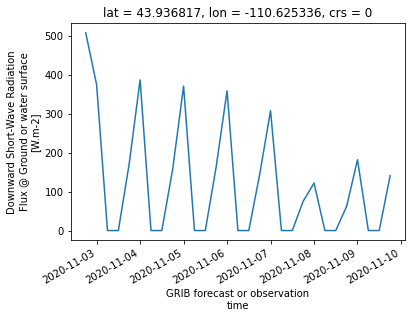

In [23]:
data_ds['Downward_Short-Wave_Radiation_Flux_surface'].isel(lon=1, lat=1).plot();

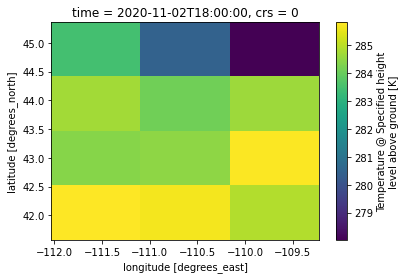

In [24]:
data_ds.Temperature_height_above_ground.sel(time='2020-10-19 07:00', method="nearest").plot();

## Reproject and resample dataset

In [25]:
x_name = 'easting'
y_name = 'northing'

In [26]:
data_reproj_ds = data_ds.rio.reproject(to_crs, resolution=to_resolution, resampling=Resampling.bilinear)
data_reproj_ds = (
    data_reproj_ds
    .rio.set_spatial_dims('x', 'y')
    # .rio.write_crs(to_crs) # this might not be needed
    .rename({"x": x_name, "y": y_name}) 
)

data_reproj_ds[x_name].attrs['long_name'] = 'Easting'
data_reproj_ds[y_name].attrs['long_name'] = 'Northing'

In [27]:
data_reproj_ds

<xarray.Dataset>
Dimensions:                                     (easting: 4, northing: 8, time: 29)
Coordinates:
  * easting                                     (easting) float64 4.39e+05 .....
  * northing                                    (northing) float64 4.999e+06 ...
  * time                                        (time) datetime64[ns] 2020-11...
    crs                                         int64 0
Data variables:
    Specific_humidity_height_above_ground       (time, northing, easting) float32 ...
    Temperature_height_above_ground             (time, northing, easting) float32 ...
    u-component_of_wind_height_above_ground     (time, northing, easting) float32 ...
    Precipitation_rate_surface                  (time, northing, easting) float32 ...
    Pressure_surface                            (time, northing, easting) float32 ...
    Downward_Long-Wave_Radp_Flux_surface        (time, northing, easting) float32 ...
    Downward_Short-Wave_Radiation_Flux_surface  (time, northing, easting) float32 ...
    v-component_of_wind_height_above_ground     (time, northing, easting) float32 ...
    Geopotential_height_surface                 (time, northing, easting) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...
    grid_mapping:                                                            ...

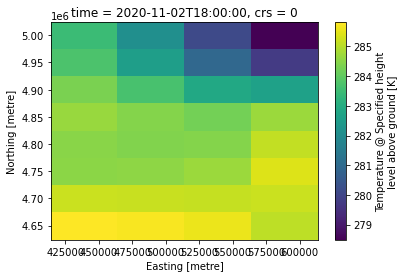

In [28]:
data_reproj_ds.Temperature_height_above_ground.sel(time='2020-10-19 07:00', method="nearest").plot();

## Export to netcdf

Can easily export to netcdf

In [29]:
data_reproj_ds.to_netcdf('CFSv2_WY_forecast4d.nc')